In [2]:
# import packages
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
from scipy.stats import chisquare

"""
IMPORTANT:
For this program to work the researcher needs to put both csv files
cycle1.csv and cycle2.csv in a folder called Observations. Run
DownloadMongoDB.ipynb to get the files. You will have to manually
put these new files in the Observations folder which will be located
in the same folder as this file.
"""

"""
Headers for Cycle1 DF (Northern Hemisphere):
_id, Original_Object_ID, MDJ, Magnitude, Magnitude_Error

Cycle1 Size: 28878 Asteroids

Headers for Cycle2 DF (Southern Hemisphere):
_id, Object_ID, MDJ, Magnitude, Magnitude_Error, Sector

Cycle2 Size: 18712 Asteroids

Overlap Size: 3025 Asteroids
"""

# import data from csv file into a pandas df
cycle1_df = pd.read_csv("Observations/cycle1.csv", low_memory=False)
cycle2_df = pd.read_csv("Observations/cycle2.csv", low_memory=False)

# get the ids that intersect
cycle1_df_unique = np.unique(cycle1_df["Object_ID"])
cycle2_df_unique = np.unique(cycle2_df["Object_ID"])
intersect_ids = np.intersect1d(cycle1_df_unique, cycle2_df_unique)

# define sine function to fit
def sine_function(x, amplitude, frequency, phase, offset):
    return amplitude * np.sin(frequency * x + phase) + offset

In [10]:
def queue_single_asteroid_by_id(asteroid_id):
    
    # Get the asteroid data for the given ID
    asteroid = cycle1_df[cycle1_df["Object_ID"] == asteroid_id]
    # asteroid = cycle2_df[cycle2_df["Object_ID"] == asteroid_id]

    """
    Derive the rotational period of an object from MDJ
    and Magnitude.
    """

    # extract MJD, magnitude, magnitude error
    time_mdj = asteroid["MJD"].values
    magnitude = asteroid["Magnitude"].values
    error = asteroid["Magnitude_Error"].values

    # define frequency range (1 to 24 hours period = 1/24 to 1 cycles/hour)
    # convert MJD to hours relative to first timestamp
    time_hours = (time_mdj - time_mdj.min()) * 24
    frequency = np.linspace(1/(max(time_hours) - min(time_hours)), 1/2, 1000000)
    power = LombScargle(time_hours, magnitude, error).power(frequency)

    # best period is 1 / frequency at peak power
    peak_index = np.argmax(power)
    peak_power = power[peak_index]
    best_frequency = frequency[np.argmax(power)]
    best_period = 1 / best_frequency

    # double the period for full rotation
    best_period = best_period * 2

    # create a lomb scargle model generating a sine curve fit
    ls = LombScargle(time_hours, magnitude, error)
    magnitude_fit = ls.model(time_hours, best_frequency)
    time_fit = np.linspace(0, best_period, len(magnitude_fit))
    magnitude_fit = ls.model(time_fit, best_frequency)
    phase = (time_hours % best_period)

    # plot the periodogram
    plt.plot(frequency, power)
    plt.show()

    # plot the lomb scargle model need to add the magnitude fit
    plt.plot(time_fit, magnitude_fit, color = "orange", linewidth = 3)
    plt.scatter(phase, magnitude, color="blue")
    plt.title(f"Light Curve Phase for: {asteroid_id}")
    plt.xlabel("Hours")
    plt.ylabel("Magnitude")
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.show()

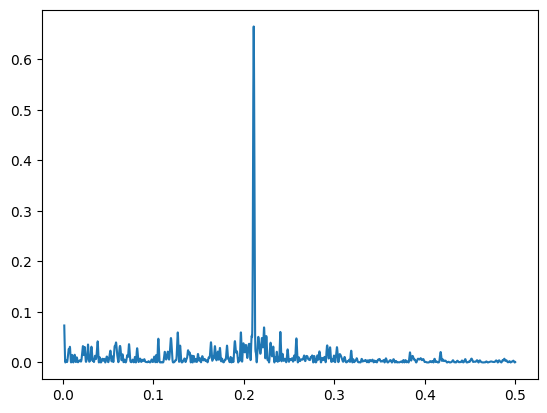

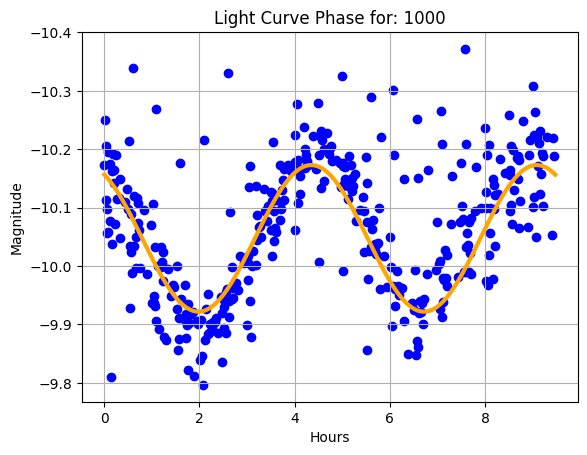

In [12]:
queue_single_asteroid_by_id("1000")